## Configuration

In [ ]:
import pandas as pd
import numpy as np
import json

In [ ]:
from src.widgets import get_config_widgets, select_features
from src.dataset import get_datasets, normalize_data
from src.feature import create_features, create_normalized_features, split
from src.prediction import linear_regression, predict_return_mae, predict_return_mse
from src.plot import plot_price_split, feature_importance, plot_predicted



In [ ]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [ ]:
price_interval, prediction_date_picker, eval_size, normalize =  get_config_widgets()

## Data loading

In [ ]:
# Load data
energy_data = pd.read_csv('../data/day_ahead_energy_prices.csv')
energy_data['Datetime'] = pd.to_datetime(energy_data['Datetime']).dt.tz_localize(None)
energy_data = energy_data.rename(columns={'Datetime': 'ds', 'hourly day-ahead energy price': 'y'})

weather_data = pd.read_csv('../data/germany_weather_average.csv')
weather_data['date'] = pd.to_datetime(weather_data['date']).dt.tz_localize(None)
weather_data.rename(columns={'date': 'ds'}, inplace=True)

market_mix = pd.read_csv('../data/hourly_market_mix_cleaned.csv')
market_mix['Timestamp'] = pd.to_datetime(market_mix['Timestamp']).dt.tz_localize(None)
market_mix.rename(columns={'Timestamp': 'ds'}, inplace=True)

merged_data = pd.merge(energy_data, weather_data, on='ds', how='left')
merged_data = pd.merge(market_mix, merged_data, on='ds', how='left')


In [ ]:
merged_df, e_price_df = get_datasets()

## Feature Selection

In [ ]:
def create_features(df, include_target=True):
    df = df.copy()

    # Extract temporal features
    df['hour'] = df['ds'].dt.hour
    df['dayofweek'] = df['ds'].dt.dayofweek
    df['dayofyear'] = df['ds'].dt.dayofyear
    df['weekofyear'] = df['ds'].dt.isocalendar().week

    if include_target:
        # Moving averages for hours (if 'y' is available)
        for window in range(2, 24):
            df[f'ma_{int(window)}_hours'] = df['y'].rolling(window=window).mean()

        # Moving averages for days (1-3 days, 1 week)
        for window in [24, 72, 168]:
            df[f'ma_{int(window / 24)}_days'] = df['y'].rolling(window=window).mean()

        # Fill NaN values in moving averages with interpolation or medians
        for column in df.columns:
            if 'ma_' in column:
                df[column] = df[column].interpolate(method='linear').fillna(df[column].median())

    return df

merged_data = create_features(merged_data)
energy_columns = [col for col in merged_data.columns if col not in ['ds', 'y']]


In [ ]:
regressors_json = '''
{
    "time_based": ["dayofweek", "dayofyear"],
    "moving_average": ["ma_2_hours", "ma_3_hours", "ma_4_hours", "ma_16_hours", "ma_19_hours", "ma_20_hours", "ma_21_hours", "ma_22_hours", "ma_23_hours"],
    "other": ["Hydro", "Solar", "temperature_2m","Precipitation (rain/snow)","direct_radiation"]
}
'''

# Load the JSON data
regressors = json.loads(regressors_json)


In [ ]:
get_features, default_features = select_features()

In [ ]:
# RERUN WHEN TICKING the NORMALIZED BOX 

selected_features = get_features()
FEATURES = default_features if not selected_features else selected_features

min_price, max_price = price_interval.value

features_df = create_features(merged_df)

features_interval_df = features_df.copy()[
    (features_df["Price"] >= min_price) &
    (features_df["Price"] <= max_price)
]
print(features_interval_df)

normalized_features_df, normalized_e_price_df, normalized_interval_df, e_price_scaler = normalize_data(features_df.copy(), e_price_df.copy(), features_interval_df.copy())

TARGET = merged_df["Price"]
TARGET_INTERVAL = features_interval_df["Price"]
TARGET_NORMALIZED = normalized_features_df["Price"]
TARGET_NORMALIZED_INTERVAL = normalized_interval_df["Price"]
print(TARGET_NORMALIZED_INTERVAL)

combined_df = pd.concat([features_df[FEATURES], TARGET], axis=1)
combined_interval_df = pd.concat([features_interval_df[FEATURES], TARGET_INTERVAL], axis=1)
combined_normalized_df = pd.concat([normalized_features_df[FEATURES], TARGET_NORMALIZED], axis=1)
combined_normalized_interval_df = pd.concat([normalized_interval_df[FEATURES], TARGET_NORMALIZED_INTERVAL], axis=1)


if normalize.value:
    train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST = split(combined_normalized_df,eval_size.value, prediction_date_picker.value)
    train_XGB, eval_XGB, test_XGB, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL = split(combined_normalized_interval_df,eval_size.value, prediction_date_picker.value)
    scalar = e_price_scaler
    # print(test)
    
else:
    train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST = split(combined_df,eval_size.value, prediction_date_picker.value)
    train_XGB, eval_XGB, test_XGB, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL = split(combined_interval_df,eval_size.value, prediction_date_picker.value)
    scalar = None

TARGET = "Price"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

X_val = eval[FEATURES]
y_val = eval[TARGET]

X_train_XGB = train_XGB[FEATURES]
y_train_XGB = train_XGB[TARGET]

X_test_XGB = test_XGB[FEATURES]
y_test_XGB = test_XGB[TARGET]

X_val_XGB = eval_XGB[FEATURES]
y_val_XGB = eval_XGB[TARGET]


In [ ]:
plot_price_split(train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST, "outliers includuded")
plot_price_split(train_XGB, eval_XGB, test_XGB, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL, "ex outliers")

## Prediction

### Linear Regression

In [ ]:
linear_regression(X_train, y_train, X_test, y_test, scalar)
linear_regression(X_train_XGB, y_train_XGB, X_test_XGB, y_test_XGB, scalar)

### Prophet

In [76]:
# Initialize Prophet model
model = Prophet(
    changepoint_prior_scale= 0.5,
    seasonality_prior_scale= 1.0,
    holidays_prior_scale= 1.0,
    seasonality_mode= 'multiplicative'
)
#Add fourier order for weekly and monthly seasonality
model.add_seasonality(name='weekly', period=7, fourier_order=10)
model.add_seasonality(name='monthly', period=30.5, fourier_order=10)
# Add time-based regressors
for regressor in regressors["time_based"]:
    model.add_regressor(regressor)

# Add moving average regressors
for regressor in regressors["moving_average"]:
    model.add_regressor(regressor)

# Add other regressors
for regressor in regressors["other"]:
    model.add_regressor(regressor)

# Split data
split_index = int(len(merged_data) * 0.82)
mid_index = (len(merged_data) + split_index) // 2
train_data, validation_data, test_data = merged_data[:split_index], merged_data[split_index:mid_index], merged_data[mid_index:]

# Fit the model with training data
model.fit(train_data)

# Prepare future dataframe with the current subset of regressors
future = test_data[['ds'] + energy_columns]

# Generate forecast
forecast = model.predict(future)

# Merge forecast with test data for evaluation
results_df = forecast.merge(test_data, on='ds', how='left')

# Calculate RMSE
mse = mean_squared_error(results_df['y'], results_df['yhat'])
rmse = np.sqrt(mse)

# Calculate MAE
mae = mean_absolute_error(results_df['y'], results_df['yhat'])

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

08:56:09 - cmdstanpy - INFO - Chain [1] start processing
08:57:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Squared Error (RMSE): 6.95
Mean Absolute Error (MAE): 4.02


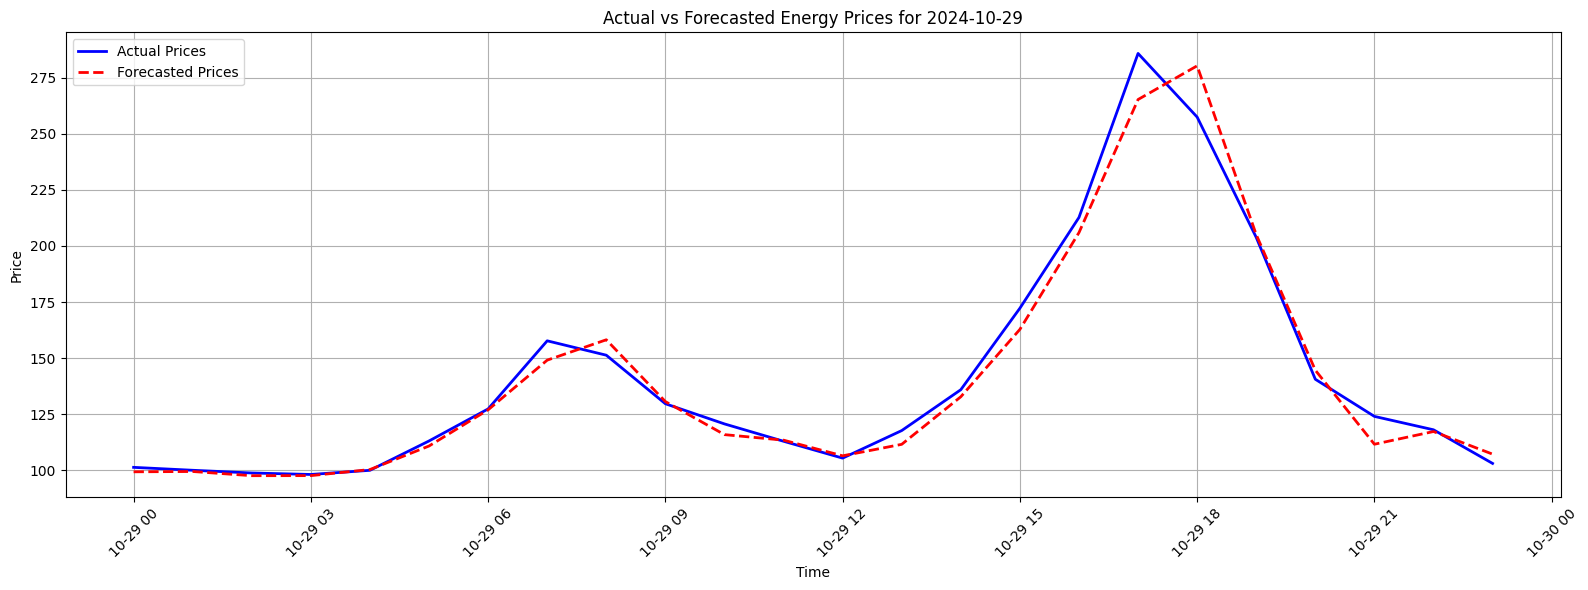

In [77]:
from hand_in.src.plot import plot_actual_vs_predicted

specific_date = '2024-10-29'
plot_actual_vs_predicted(results_df, specific_date)

### XGBoost

In [ ]:
best_params = {
    "base_score": 0.380924762889507,
    "early_stopping_rounds": 215,
    "max_depth": 80,
    "learning_rate": 0.06,
    "n_estimators": 150,
    "gamma": 0.9,
    "min_child_weight": 6,
    "subsample": 0.5719023844219375,
    "colsample_bytree": 0.8815691043681952,
}

y_predicted_mse, model_mse = predict_return_mse(best_params, X_train_XGB, y_train_XGB, X_val_XGB, y_val_XGB, X_test_XGB)
y_predicted_mae, model_mae = predict_return_mae(best_params, X_train_XGB, y_train_XGB, X_val_XGB, y_val_XGB, X_test_XGB)

In [ ]:
feature_importance(model_mse, "MSE")
feature_importance(model_mae, "MAE")

In [ ]:
for predictions, objective_name in [(y_predicted_mse, "MSE"), (y_predicted_mae, "MAE")]:
    plot_predicted(test, predictions, objective_name)
    

## Results